# Krypton Lifetime

## Produce lifetime map and write a DST with lifetime-corrected energies

### Input files

In [76]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_4999.h5', 'dst_6206_5001_9999.h5','dst_6206_10001_19999.h5']
output_file_name  = 'ldst_6206_0000_19999.h5'
map_file_name     = 'lmap_6206_0000_19999.h5'

### Notebook configuration

In [77]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [78]:
import os
import time
import datetime
import collections
import glob
import warnings
import matplotlib.pyplot as plt

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [79]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits

from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import divide_np_arrays
from core.kr_core_functions import file_numbers_from_file_range
from core.kr_core_functions import fiducial_volumes
from   invisible_cities.evm  .ic_containers  import Measurement

In [80]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [81]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [82]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [83]:
from typing      import NamedTuple

In [84]:
# Plotting style
default_cmap = "viridis"
figure_size  = 8, 6
font_size    = 15

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)

profOpt = "--k"
fitOpt  = "r"


In [85]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [86]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Mon Jul 16 20:25:30 2018


### Read data

In [87]:
path  = input_path
opath = output_path
mpath = map_path

input_dst_filenames = [os.path.expandvars(f"{path}/{file_name}") for file_name in input_file_names]
output_dst_filename = os.path.expandvars(f"{opath}/{output_file_name}")
map_filename        = os.path.expandvars(f"{mpath}/{map_file_name}")


print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_4999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10001_19999.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6206_0000_19999.h5


In [88]:
dst           = krc.load_dsts(input_dst_filenames, "DST", "Events")

In [89]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 2606375


In [90]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [91]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 12.5e3),
                                                              S1range = (   2,   25),
                                                              Qrange  = ( 100, 800),
                                                              Znbins        =   10,
                                                              XYnbins       =   60,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [92]:
print(krRanges, krNBins)

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 12500.0), S1=(2, 25), Q=(100, 800), T=(1531471716.4420002, 1531607454.6619999)) KrNBins(Z=10, XY=60, E=50, S1=20, Q=25, T=37)


### Fiducial volumes

In [93]:
kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 2544271: eff_full = 0.976172269915112 
 nfid : 1412009: eff_fid = 0.5417520502613784 
 ncore : 619991: eff_core = 0.23787482614742697 
 nhcore : 154786: eff_hcore = 0.059387463431010507 


### Time 

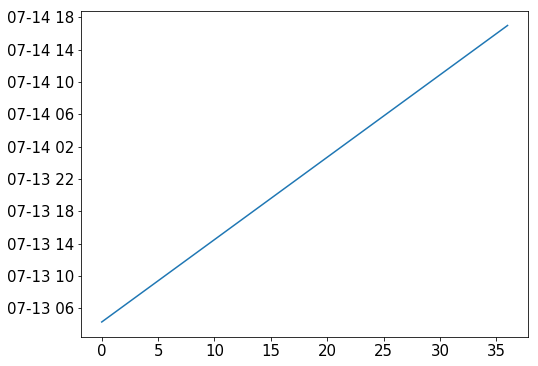

In [94]:
plt.plot(krTimes.timeStamps)

### Event distribution

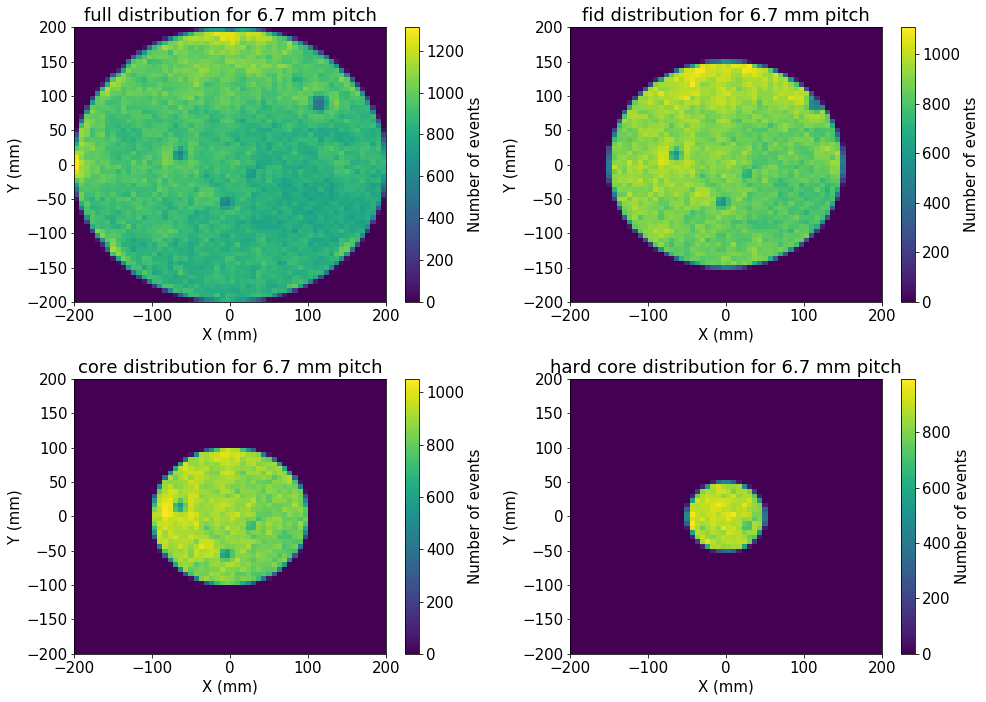

In [95]:
nEvt = krp.plot_xy_density(kdst, krBins)

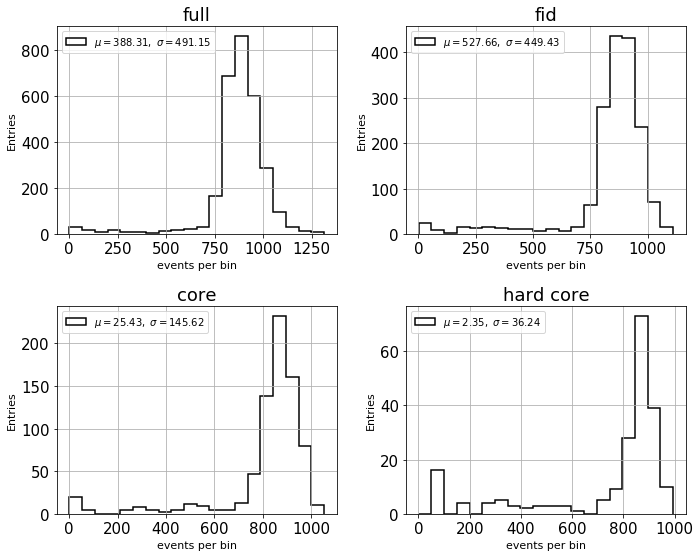

In [96]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

### Evolution of S12 with time full

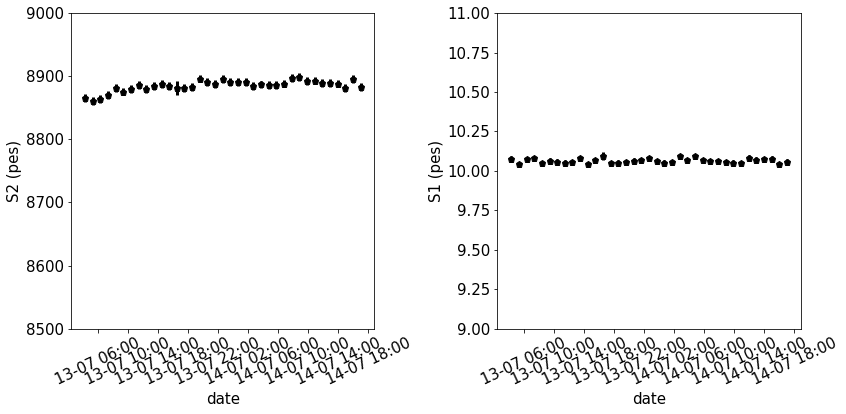

In [97]:
krf.s12_time_profile(kdst.full, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(8500, 9000), s1lim=(9,11), figsize=(12,6))

### Evolution of S12 with time hard core

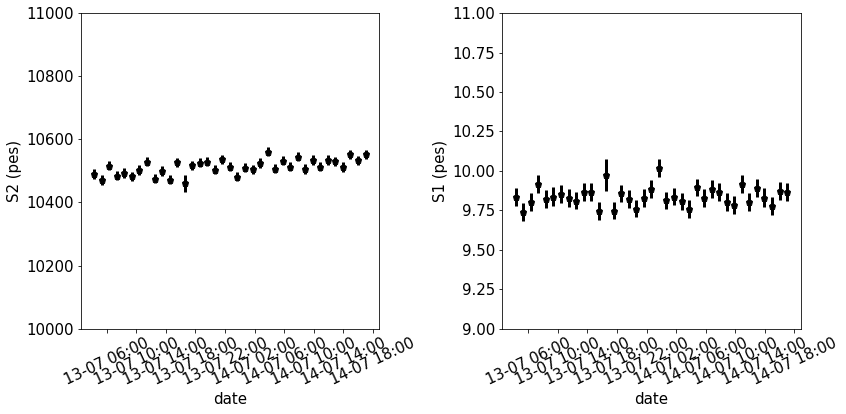

In [98]:
krf.s12_time_profile(kdst.hcore, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(10000, 11000), s1lim=(9,11), figsize=(12,6))

### S2 & S1 full

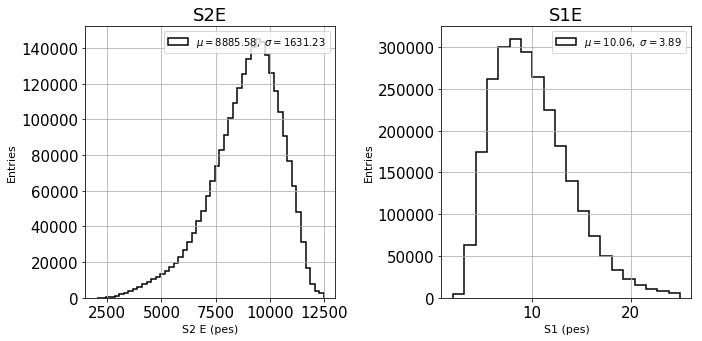

In [99]:
stats = krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.full.E, kdst.full.S1), bins=(krNBins.E, krNBins.S1), 
                names = ('S2E','S1E'),
                ranges =(krRanges.E, krRanges.S1),
                xlabels =('S2 E (pes)','S1 (pes)'),
                ylabels =('Entries','Entries'),
                titles = ('S2E','S1E'),
                legends = ('best','best'),
                figsize =(10,5))

In [100]:
stats

{'S1E': Measurement(value=10.063217956996546, uncertainty=3.8939082779868484),
 'S2E': Measurement(value=8885.5755641933411, uncertainty=1631.2292734328323)}

### S2 & S1 hard core

{'S1E': Measurement(value=9.8362820451107424, uncertainty=3.7021368694378096),
 'S2E': Measurement(value=10503.05165277931, uncertainty=951.32640623453176)}

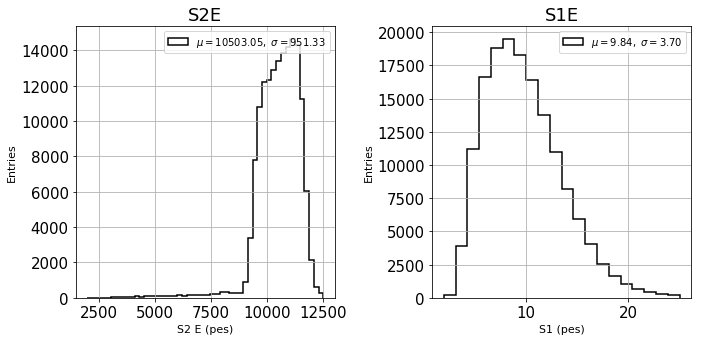

In [101]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.hcore.E, kdst.hcore.S1), bins=(krNBins.E, krNBins.S1), 
        names=('S2E','S1E'),
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 vs Z

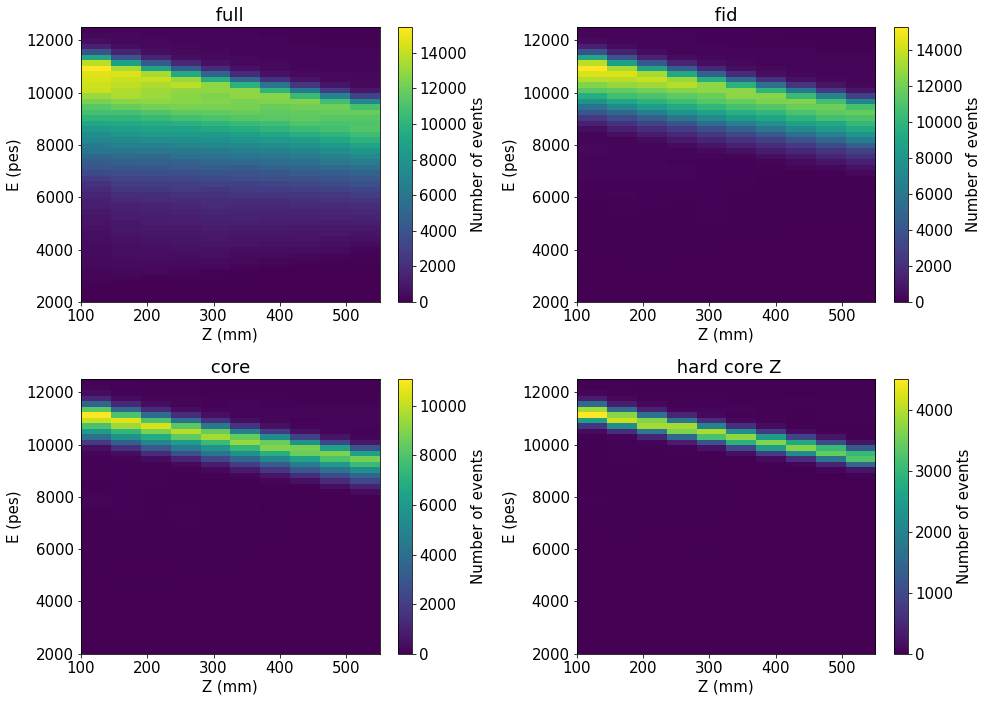

In [102]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit lifetime in hard core

 E (z=0) = 11548.056597937053 +-6.11812679749986 
 LT      = -2805.401354747809 +-11.54764223213593 
 chi2    = 2.04960198620113 


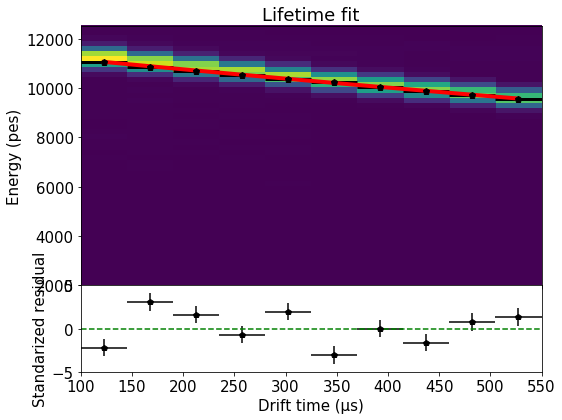

In [103]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.hcore, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit lifetime in core

 E (z=0) = 11308.378868647407 +-3.2550379772970754 
 LT      = -2707.9562518842135 +-5.946431801244924 
 chi2    = 2.333233356233846 


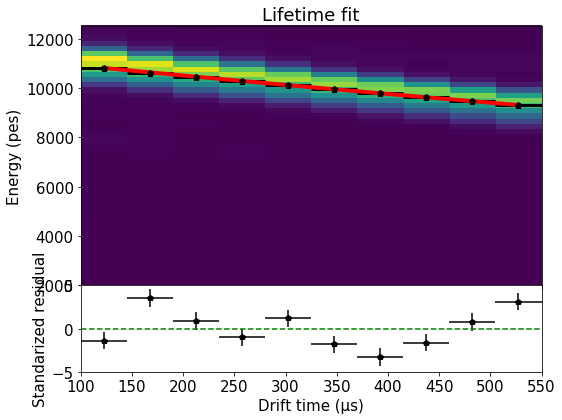

In [104]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.core, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11096.749962629037 +-12.347036231271595 
 LT      = -2684.1646953352856 +-21.75437883357266 
 chi2    = 1.6906699617173961 
 E (z=0) = 10201.494339318244 +-12.54292474788963 
 LT      = -2380.6145525559728 +-19.635169173566364 
 chi2    = 1.216620344441196 
 E (z=0) = 9885.642500348005 +-11.195073428562194 
 LT      = -2301.5409304077552 +-17.39571446316345 
 chi2    = 1.080158477878768 
 E (z=0) = 10312.349350820128 +-10.819277148189808 
 LT      = -2542.418259918385 +-19.689737176041852 
 chi2    = 0.9654626980133166 


[None, None, None, None]

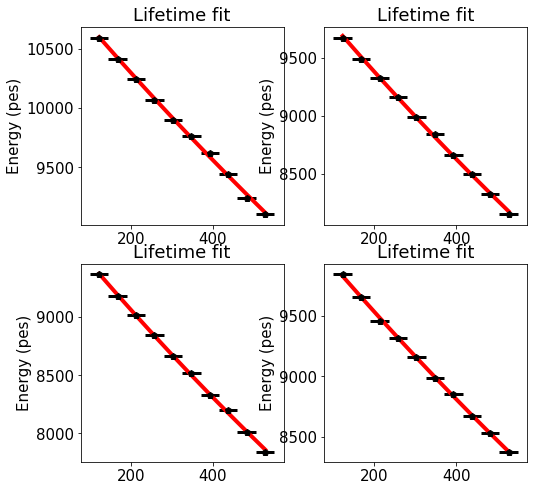

In [105]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit low and hig regions

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9609.125836928142 +-8.93737378354703 
 LT      = -2178.6026200583788 +-13.098229710815273 
 chi2    = 1.8774275162413137 
 E (z=0) = 10893.368423626094 +-4.974363377576794 
 LT      = -2798.991271159402 +-10.3578892032665 
 chi2    = 2.193295560608197 


[None, None]

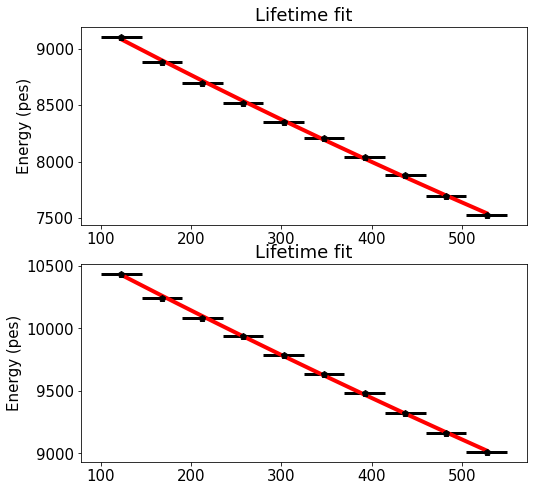

In [106]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [107]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 9609.125836928142 +- 8.93737378354703
High:  es +- err = 10893.368423626094 +- 4.974363377576794
LOW:  lt +- err = 2178.6026200583788 +- 13.098229710815273
High:  lt +- err = 2798.991271159402 +- 10.3578892032665


### Time profile of LT in the fiducial

In [108]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

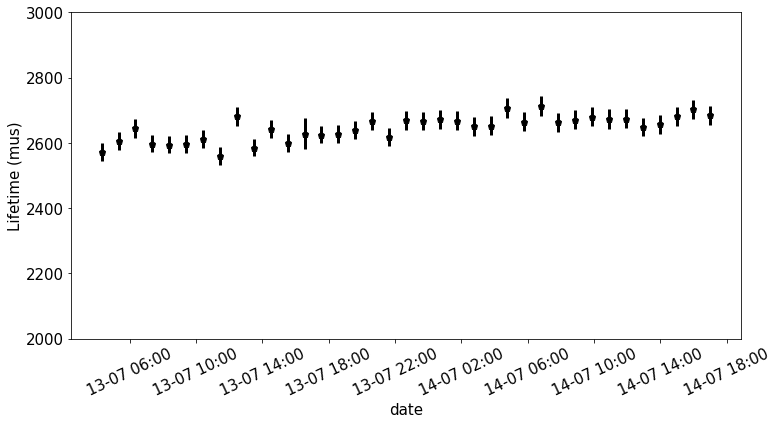

In [109]:
krp.plot_lifetime_T(fits, krTimes.timeStamps, ltlim=(2000, 3000),  figsize=(12,6))

### Time profile of LT in hard core

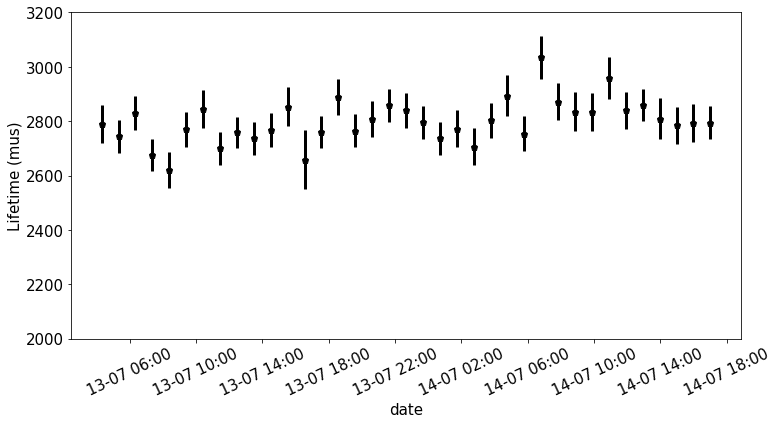

In [111]:
fits = krf.lifetimes_in_TRange(kdst.hcore, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps,ltlim=(2000, 3200),  figsize=(12,6))

### Compute lifetime maps

In [112]:
krfs = krf.fit_lifetime_slices(kdst.full, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [113]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [114]:
valid.shape

(60, 60)

In [115]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.7877777777777778

In [116]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =2365.923599020994 +- 461.6652744237744
Lifetime uncertainty     : mu +- std =4.5739921288920895 +- 2.1096997547668725
Energy scale value       : mu +- std =9999.272481775533 +- 1335.1418039112104
Energy scale uncertainty : mu +- std =0.7133117319698569 +- 0.4271008721869926


In [117]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 6661.417971997507; E_max = 13337.12699155356
 Lifetime (ELT): ELT_min = 1211.7604129615581; ELT_max = 3520.0867850804298
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 1.7810639124373382
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 9.84824151580927


### Map display

In [118]:
invalid = ~valid
mask = valid

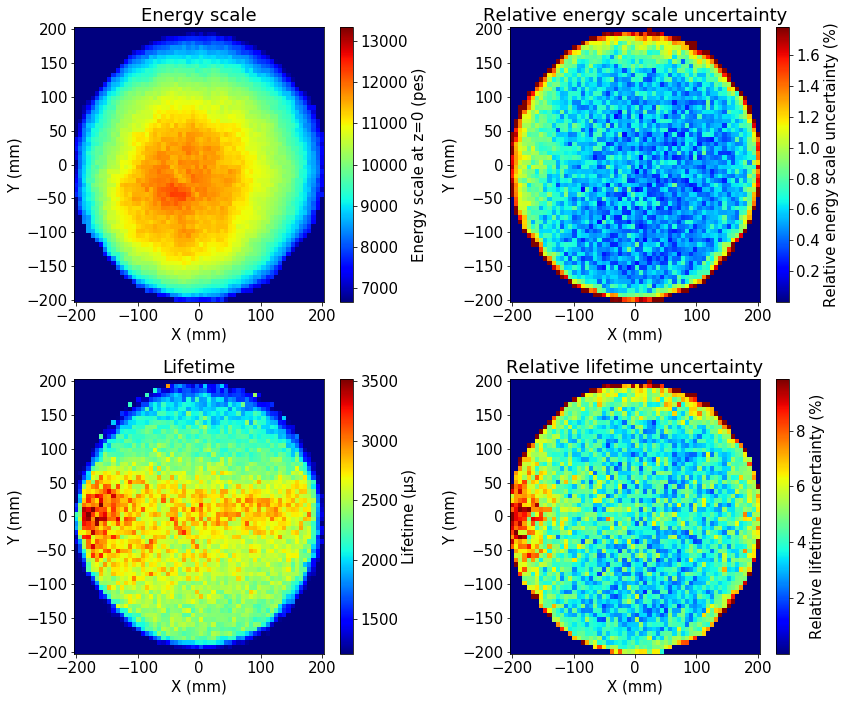

In [119]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=valid)
                         

(1.2348666541655258, 0.62730693032592555)

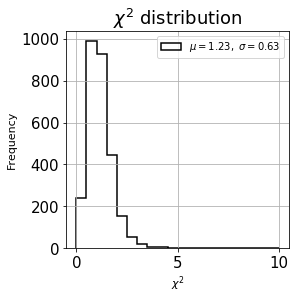

In [120]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

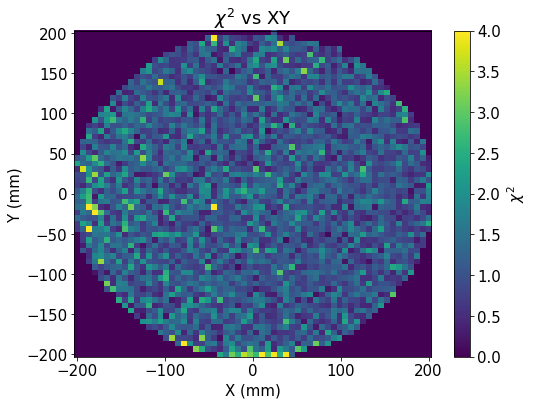

In [121]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

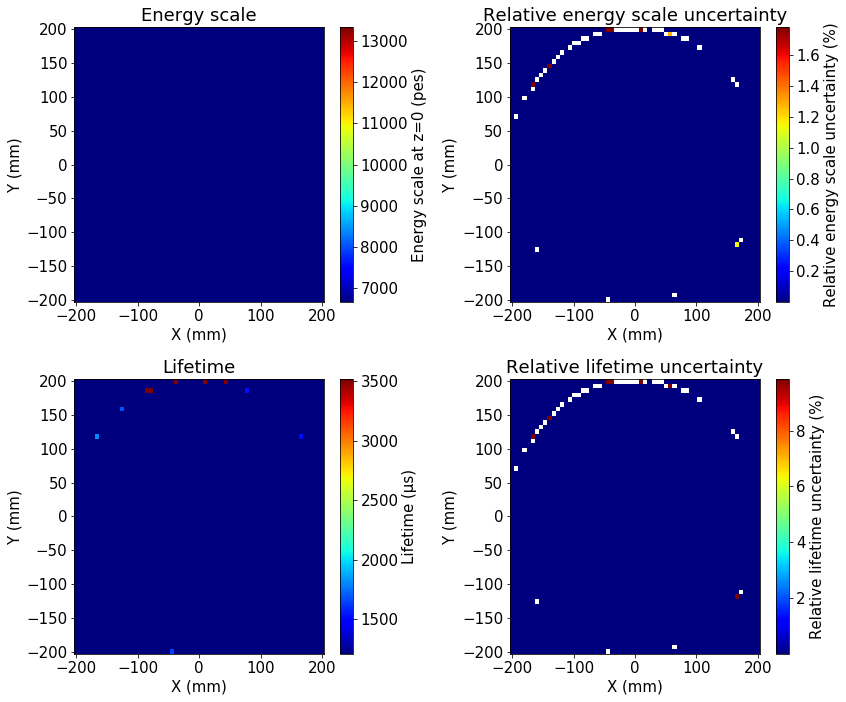

In [122]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=invalid)

### Fix map

- Fit fails in the corona
- Fill bins where fit has failed with average low level of lifetime


Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [123]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))

In [124]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

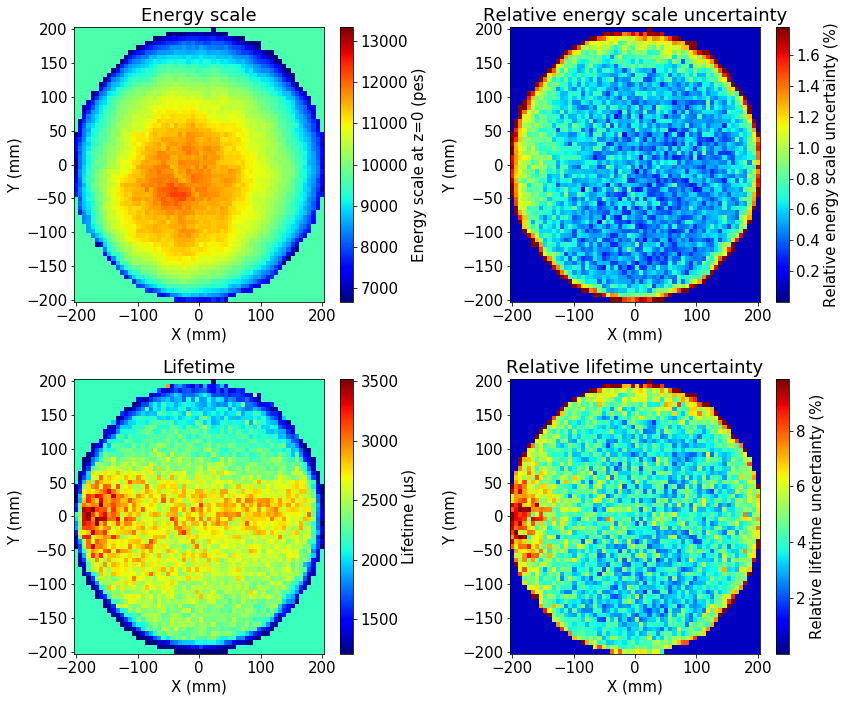

In [125]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=None)

In [126]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [127]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [128]:
gfid(gvalid)

In [129]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.7855555555555556

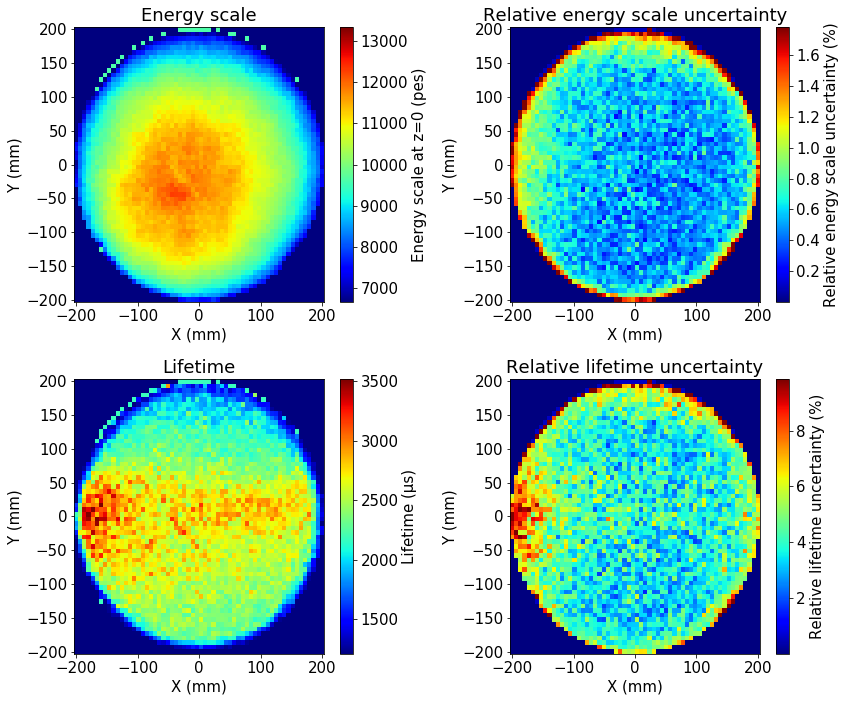

In [130]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)

### Produce HDF5 output

In [131]:
nevt = nEvt.fid

In [132]:
print(map_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6206_0000_19999.h5


In [133]:
with tb.open_file(map_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY



### Load Z correction function

In [134]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(map_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

### Correct DST by lifetime

In [135]:
E = np.copy(dst.S2e.values)

In [136]:

dst.S2e = dst.S2e.values * ZcorrectionE(dst.Z, dst.X, dst.Y).value

In [137]:
Ec = dst.S2e.values

{'Ecorr ': Measurement(value=9842.1973173970982, uncertainty=1706.284645699955),
 'Eraw ': Measurement(value=8796.9281271935088, uncertainty=1719.5876733920175)}

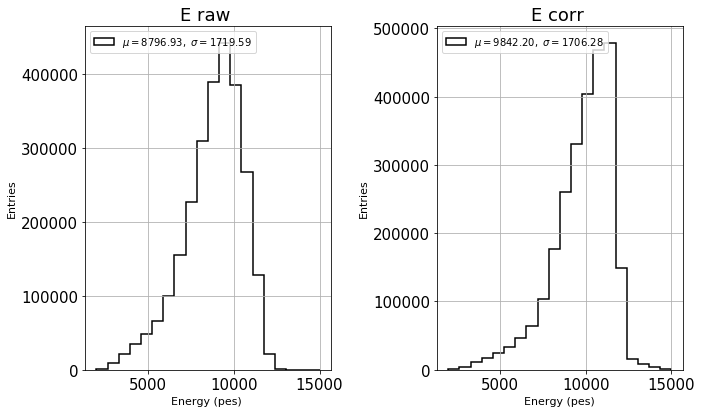

In [138]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (E, Ec),
    bins = (20, 20),
    names = ("Eraw ", "Ecorr "),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E raw ", "E corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

### Time profile

In [139]:
kdstc= kr_event(dst)

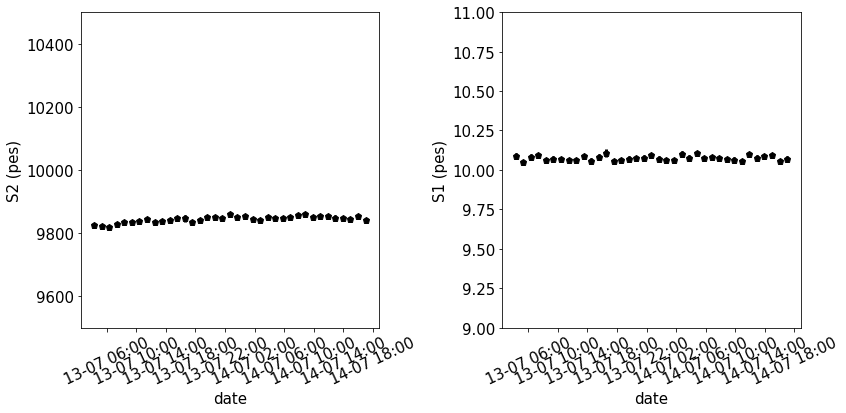

In [140]:
krf.s12_time_profile(kdstc, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(9500, 10500), s1lim=(9,11), figsize=(12,6))

### Time correction

In [141]:
e_mu    = np.nanmean(kdstc.E)
print(e_mu)
e_std   = np.nanstd (kdstc.E)
print(e_std)

9844.1327757
1709.05661356


In [142]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

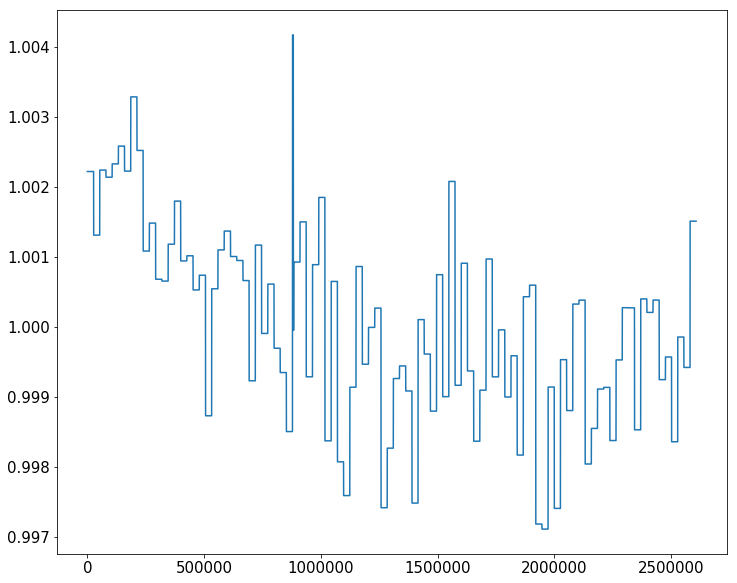

In [143]:
plt.plot(ET_correction(T).value)

In [144]:
ekr_mu    = np.nanmean(Ekr)
ekr_std   = np.nanstd (Ekr)
print(ekr_mu)
print(ekr_std)

9844.13360609
1709.01690857


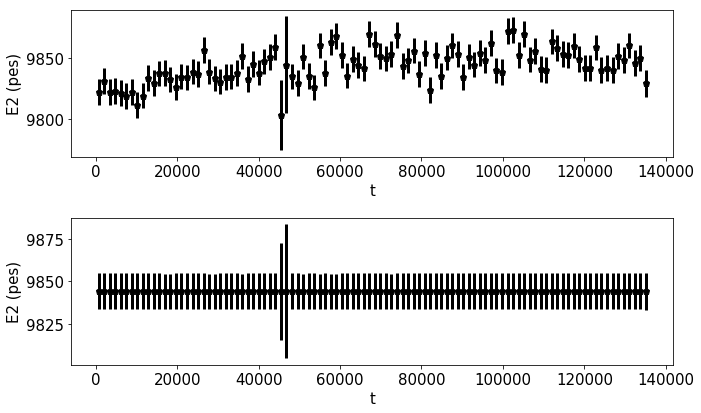

In [145]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)

plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)

plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')
plt.tight_layout()

### Notice scale. Time fluctuation below 1 %

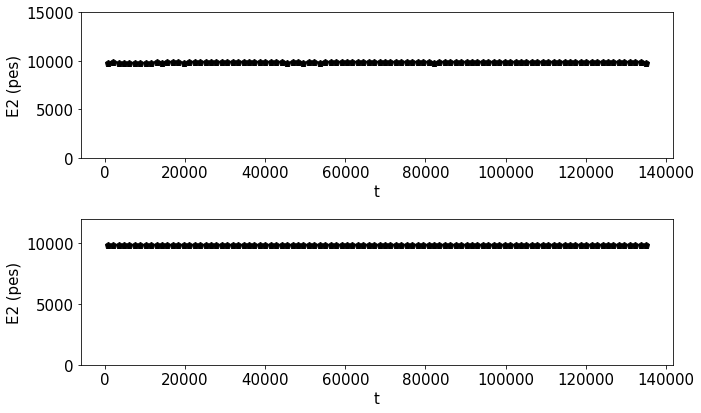

In [146]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)
plt.ylim(0, 15000)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)
plt.ylim(0, 12000)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

plt.tight_layout()



{'E_lt_T_corr ': Measurement(value=9844.1430907064732, uncertainty=1709.9428939724007),
 'E_lt_corr': Measurement(value=9842.1973173970982, uncertainty=1706.284645699955)}

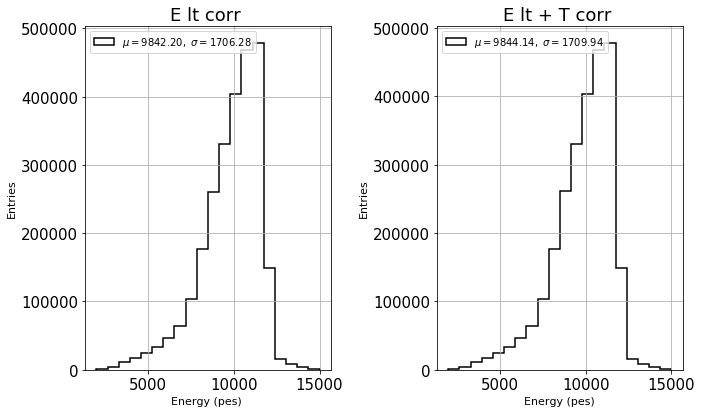

In [147]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (Ec, Ekr),
    bins = (20, 20),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E lt corr ", "E lt + T corr "),
    names = ("E_lt_corr", "E_lt_T_corr "),   
    legends = ("upper left", "upper left"),
    figsize =(10,6))

In [148]:
dst.S2e = E

In [149]:
del dst["index"]

### Write LT DST

In [150]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

